训练集大小: 60000
测试集大小: 10000
epoch:1,train_loss:0.1882,train_acc:0.9435
epoch:2,train_loss:0.0508,train_acc:0.9840
epoch:3,train_loss:0.0372,train_acc:0.9882
epoch:4,train_loss:0.0255,train_acc:0.9915
epoch:5,train_loss:0.0192,train_acc:0.9941
epoch:6,train_loss:0.0161,train_acc:0.9947
epoch:7,train_loss:0.0132,train_acc:0.9957
epoch:8,train_loss:0.0098,train_acc:0.9970
epoch:9,train_loss:0.0084,train_acc:0.9971
epoch:10,train_loss:0.0069,train_acc:0.9973


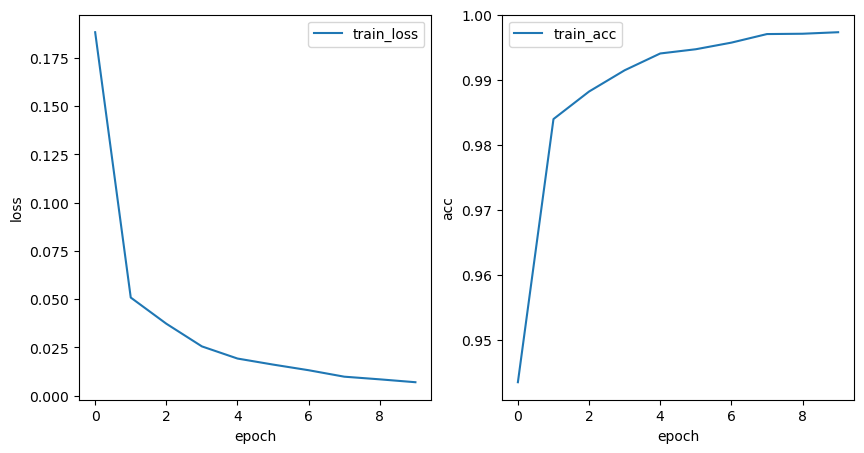

test_acc:0.9920


In [7]:
#引入错误的处理机制
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # 允许重复加载 OpenMP，解决 libiomp5md.dll 冲突

# 导入包
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   
import time
import random
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

#引入数据集
train_dataset=datasets.MNIST(root='data',train=True,download=True,transform=transforms.ToTensor(),)
test_dataset=datasets.MNIST(root='data',train=False,download=True,transform=transforms.ToTensor(),)


#创建数据加载器
batch_size=64
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

#检测数据是否引入
print("训练集大小:", len(train_dataset))
print("测试集大小:", len(test_dataset))

#检测设备情况
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("使用设备:", device)

#定义卷积神经网络模型
class mycnn(nn.Module):
    def __init__(self):
        super(mycnn,self).__init__()
        self.conv1=nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)  # 输入通道1，输出通道32，卷积核大小3x3
        self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.pc1=nn.Linear(64*7*7,128)  # 全连接层，输入大小为64*7*7
        self.pc2=nn.Linear(128,10) #最后的输出是10个类别
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2)  # 最大池化层，池化大小为2x2
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2)  # 最大池化层，池化大小为2x2
        x=torch.flatten(x,start_dim=1)  # 展平操作
        x=F.relu(self.pc1(x))
        x=self.pc2(x)
        return x

#创建我的model
model=mycnn()
#放置到GPU上 加快训练速度
model.to(device)

#定义损失函数和优化函数
criterion=nn.CrossEntropyLoss() #交叉熵损失函数
optimizer=torch.optim.Adam(model.parameters(),lr=0.001) #优化函数

epoches=10

train_loss=[]
train_acc=[]


#开始循环
for epoch in range(epoches):
    #模型设置为训练模式
    model.train()
    runing_loss=0.0
    correct=0
    total=0
    for images ,labels in train_loader:
        images,labels=images.to(device),labels.to(device)
        optimizer.zero_grad() #梯度清零
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        runing_loss+=loss.item()
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=predicted.eq(labels.data).cpu().sum()
        
    avg_loss=runing_loss/len(train_loader)
    avg_acc=correct/total
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)
    print('epoch:{},train_loss:{:.4f},train_acc:{:.4f}'.format(epoch+1,runing_loss/len(train_loader),correct/total))
    
    
#绘制训练的各种参数的曲线
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc,label='train_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

#开始进行测试
model.eval() #设置为测试模式
correct=0
total=0
with torch.no_grad():
    for images,labels in test_loader:
        images,labels=images.to(device),labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=predicted.eq(labels.data).cpu().sum()
print('test_acc:{:.4f}'.format(correct/total))

#保存模型
torch.save(model.state_dict(),'mnist.pth')

